# RECOMMENDER SYSTEM

-- AUTHOR: ZIQING LU

-- NUID: 001805353


## 1.INTRODUCTION

### 1.1 WHAT IS A RECOMMENDER SYSTEM?

What is a recommender system? Why do we need a recommender system? 

In modern society, people usually have too many options to choose from due to the prevalence of internet. Recommender system is a solution to this information overload problem.

The Recommender System captures patterns in user behavior and helps predict what users like. Ecommerce websites, social media, content platforms, etc. are actively using recommender systems to personalize users’ experience online and help users choose products. 

"The Long Tail" theory tells us 80% sales come from popular items. However virtual shelf cost is extremely low in the context of Ecommerce booming, and the rest "unpopular" items could satisfy the customized need of small group of people and provide huge interest to Ecommerce sites. This long tail cannot be neglected. And it is where a recommender system can unleash its power.

![The Long-tail of popularity of items](https://smashey.files.wordpress.com/2010/04/long-tail.gif)

[Image Source](https://smashey.wordpress.com/2010/04/25/the-long-tail-of-life/)


### 1.2 OVERVIEW OF RECOMMENDER SYSTEM METHODS



There are 3 fundamental methods to build a recommender system - Content-based filtering, Collaborative filtering, and hybrid filtering. 

1. **Content-based filtering (BF)** methods are based on a description of the item and a profile of the user's preferences, [source](https://en.wikipedia.org/wiki/Recommender_system#cite_note-Aggarwal16Book-41) and then recommend the items that is similar to the most liked ones by this user.



2. **Collaborative filtering (CF)** is based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past. The system generates recommendations using only information about rating profiles for different users or items. By locating peer users/items with a rating history similar to the current user or item, they generate recommendations using this neighborhood. [source](https://en.wikipedia.org/wiki/Recommender_system#cite_note-Aggarwal16Book-41) 

3. **Hybrid filtering** combines different recommenders. One common hybrid recommender is to CB and CF.

![](https://miro.medium.com/max/3630/1*rCK9VjrPgpHUvSNYw7qcuQ@2x.png)

[Image Source](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada)

## 2.PROBLEM FORMULATION

### 2.1 BACKGROUND



In this artical, we will go through different algorithms of recommender system. For each of them, we will describe their major concept, present the way they work, and discuss their pros and cons.

All of the discussion for each algorithm will be based on a **movie recommendation problem**, i.e, what movies do we recommend to target user? how do we predict the ratings for movies that has not been rated by target user?

Below are the details of the dataset used in this notebook:

* Database: *MovieLens* (small)
* Link: https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset
* File used: *movies.csv, ratings.csv, tags.csv*

### 2.2 ENVIRONMENT SET-UP

#### 2.2.1 Load The Notebook

I used Google Colab to write this notebook. Please follow set-up details below to check the content of the Notebook and reproduce the results.

1. Load The Notebook:
  
  Option 1:

  * Open shared view of the original Google Colab Notebook: https://colab.research.google.com/drive/1BrRl_1HXcMhYTX2mrhsJJlrFI8DpTVVD

  * Click "File" in Menu - "Save a Copy in Drive" - Open the saved version using your own Google Colab account.

  Option 2:

  * upload the file *INFO7390_ResearchPortfolio_RecommenderSystem.ipynb* to your own Google Colab Platform.

2. Upload Data Files:

  Option 1:

  * Click "File" in Left Panel
  * "Upload" Needed 3 Data Files mentioned in Background Section

  Option 2:

  * Upload the 3 files to your Google Drive
  * Click "File" in Left Panel
  * Click "Mount Drive" to connect files in your Google Drive and your Google Colab Notebook.

Then you can run the code as well as check the text content using your own Colab.

#### 2.2.2 Load Basic Libraries and Set Working Directory

In [0]:
# Load basic libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import warnings; warnings.simplefilter('ignore')

I changed the working directory to my data folder

In [0]:
os.chdir('/content/drive/My Drive/INFO7390-AdvDataSci/Recommender System/movielens-small')

### 2.3 DATA REVIEW

#### 2.3.1 Set Up Environment and Load Data

In [0]:
# Load data
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
ratings = pd.read_csv('ratings.csv')

In [0]:
movies['genres'] = movies['genres'].str.replace('|',' ')
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy


In [0]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [0]:
tags.head(2)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


#### 2.3.2 Data Cleaning

1. Only keep users that rated over 50 movies and relevant tags, movies information

In [0]:
# Limit ratings to users rated over 20 movies
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 20)

# MovieId list after filtering according to rating 
movie_list = ratings_f.movieId.unique().tolist()

# Filter the movies dataframe
movies_f = movies[movies.movieId.isin(movie_list)]

# Filter the tags dataframe 
tags_f = tags[tags.movieId.isin(movie_list)]

2. Drop timestamp column

In [0]:
tags_f.drop(['timestamp'], 1, inplace=True)
ratings_f.drop(['timestamp'], 1, inplace=True)

3. Build Movie Title-ID map

In [0]:
movie_map = dict(zip(movies_f.title.tolist(), movies_f.movieId.tolist()))
list(movie_map.items())[:2]

[('Toy Story (1995)', 1), ('Jumanji (1995)', 2)]

In [0]:
# check # unique users and movies

n_users = ratings_f['userId'].unique().shape[0]
n_items = ratings_f['movieId'].unique().shape[0]
print('Number of users = ' + str(n_users) + '  |  Number of movies = ' + str(n_items) )

Number of users = 610  |  Number of movies = 9724


#### 2.3.3 Long-Tail Plot

Below function to produce the long-tail plot is from python library: [recmetrics](https://github.com/statisticianinstilettos/recmetrics)

In [0]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    interaction_type: str
        type of user-item interactions
        i.e. 'purchases', 'ratings' 'interactions', or 'clicks'
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)
    x_tables bool, default=True
        if True, plot x-axis tick labels
        if False, no x-axis tick lavels will be plotted.
    Returns:
    -------
        A long tail plot
    """
    #calculate cumulative volumes
    volume_df = pd.DataFrame(df[item_id_column].value_counts())
    volume_df.reset_index(inplace=True)
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df.percent_of_total_volume <= percentage]
        tail = volume_df[volume_df.percent_of_total_volume > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()

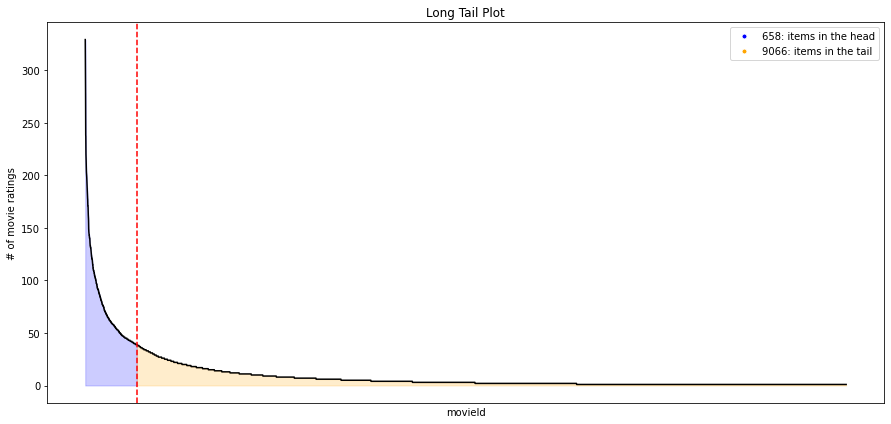

In [0]:
fig = plt.figure(figsize=(15, 7))
long_tail_plot(df=ratings_f, 
               item_id_column="movieId", 
               interaction_type="movie ratings", 
               percentage=0.5,
               x_labels=False)

## 3.EVALUATION

As a business application, there are many things to be considered when building a recommender system:

* Are my **users satisfied** with the recommended items?
  
  * Here user feedback, click-through-rate, conversion rate could be used to measure this point.

* If the recommender has a wide **coverage** and is capable to discover long-tail items?

* Does the recommender provide **diversity**?

* If this recommender helps meet my **business target**?

* If this recommender **real-time**?

* If this recommender is **explainable**?

...

For an machine learning scientist, the most important metric to train and evaluate a recommender is **ACCURACY**. 

* For recommenders like collaborative filtering engines that has a **numeric output** (predicted ratings), its accuracy can be evaluated by gap between actual and predicted ratings:
  
  * **RMSE** $= \sqrt{\frac{1}{n}\sum_{i=1}^n(Y_i-\hat{Y_i})^2}$
    * square root of the average of squared error
  * **MSE** $= \frac{1}{n}\sum_{i=1}^n(Y_i-\hat{Y_i})^2$
    * average of squared error
  * **MAE** $= \frac{1}{n}{\sum_{i=1}^n\left| Y_i-\hat{Y_i}\right|}$
    * measures the average magnitude of the errors
  
  Differences:
  * RMSE squares errors before average them, thus giving big punishment to big errors. It's useful when large errors are expected to be avoided. 
  * Compared to MSE, RMSE would bring the unit back to actual unit on the vertical axis.

* For recommenders like content-based filtering engines that produces **a ranked list of N recommended items** for a user or if we **binarize the user-item interaction prediction**, we can evaluate the accuracy by: 

  *   **Precision@N** $ = \frac{\sum_\limits{u\in\text{U}} |{R}_{(u)} \cap {T}_{(u)}|}{\sum_\limits{u\in\text{U}}|{R}_{(u)}|}$ 

      * N: an integer set by the user to match the top-N recommended items
      * u: user
      * U: all users 
      * R(u): Top-N recommended items for user u
      * T(u): Relevant items (that is liked/interacted by user u) in reality

    Suppose that Precision@10 in a top-10 recommendation problem is 80%. This means that 80% of the recommendation I make are relevant to the user.
    
    [reference](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)

  *   **Recall@N** $ = \frac{\sum_\limits{u\in\text{U}} |{R}_{(u)} \cap {T}_{(u)}|}{\sum_\limits{u\in\text{U}}|{T}_{(u)}|}$

      * N: an integer set by the user to match the top-N recommended items
      * u: user
      * U: all users 
      * R(u): Top-N recommended items for user u
      * T(u): Relevant items (that is liked/interacted by user u) in reality

    Suppose that Recall@10 in a top-10 recommendation problem is 40%. This means that 40% of the total number of the relevant items appear in the top-k results.
        
    [reference](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)




In [0]:
# generate training and testing dataset

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings_f, test_size=0.25)

In [0]:
test_data.head(2)

,userId,movieId,rating
21036,139,66934,3.5
26615,182,3301,4.0


## 4.ALGORITHM EXPLORATION

### 4.1 CONTENT-BASED FILTERING

#### 4.1.1 Concept

The core of this recommender engine is to compute the **similarity** between items based on their intrinsinc features rather than consumer feedbacks and then recommender will push similar item to users based on each user's preference history.

There are several key ideas related with content-based filtering:

1. How do we extract the "**content features**" of the items? 

  For some items, it's easy to leverage their **metadata** and convert to "features". For example, for a movie, there might be information available like director, production year, genres, crews, etc. 

  For items that just have a description, we need to figure out a method to extract features. Most common way to retrive information is using **TF-IDF**, which is a sub-area of Natural Language Processing(NLP). TF-IDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. [source: wiki](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

  - TF-IDF = TF * IDF

  - TF: Term Frequency is frequency a term appears in current document. 
  
    - **TF** $ = \frac{\text{frequency occurence of term t in document}}{\text{total number of terms in document}}$

  - IDF: Inverse Document Frequency is a measure of how important the word is to help describe the item, i.e., if it's common or rare across all documents. 
  
    - **IDF** $ =\operatorname{log}_{10} \left(\frac{\text{total number ofdocuments}}{\text{number of documents containing term t}}\right)$

2. Represent item with **feature vectors**

  After extracting features for each of the content, vectors, which represent the content and features, can be constructed for each of the items.

3. How do we measure **similarity**? 

   Various methods can be used for measuring similarity between vector A and B:
  * **Cosine Similarity**
  
    $\cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}}}$

  * **Pearson's Correlation**

    $\rho_{A,B}= \frac{\operatorname{cov}(A,B)}{\sigma_A \sigma_B} = \frac{\operatorname{E}[(A-\mu_A)(B-\mu_B)]}{\sigma_A\sigma_B} = \frac{\sum ^n _{i=1}(A_i - \bar{A})(B_i - \bar{B})}{\sqrt{\sum ^n _{i=1}(A_i - \bar{A})^2} \sqrt{\sum ^n _{i=1}(B_i - \bar{B})^2}}$

  Pearson Correlation Coefficient as demeaned version of Cosine Similarity.

    * **Euclidean Distance**
  
  $\qquad\text{distance}_{(A, B)} = \sqrt{\sum\limits_{i=1}^{n}{(A_i - B_i)^2}}$

  Euclidean distance is not scale invariant, therefore scaling the data is needed. 

#### 4.1.2 Example

[reference_1](https://github.com/youonf/recommendation_system/blob/master/content_based_filtering/content_based_recommender_approach1.ipynb)

[reference_2](https://github.com/oekosheri/Recommender-movie/blob/master/Recom_walk_through.ipynb)


Create metadata column using tags and genres

In [0]:
# create a mixed dataframe of movies title, genres 
# and all user tags given to each movie
mixed = pd.merge(movies_f, tags_f, on='movieId', how='left')
mixed.head(3)

# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies_f, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance


Build tfidf matrix using metadata

In [0]:
# build movie description tfidf matrix 

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word',
                             ngram_range=(1, 2),
                             min_df=0, 
                             stop_words='english', 
                             max_features=10000
                             )
tfidf_matrix = vectorizer.fit_transform(Final['metadata'])

# tfidf_features = vectorizer.get_feature_names()
tfidf_matrix.shape

(9724, 5452)

Compute similarity

In [0]:
# compute Cosine Similarity

from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [0]:
# compute Euclidean Distance Similarity

from sklearn.metrics.pairwise import euclidean_distances
euclidean_similarity = euclidean_distances(tfidf_matrix)

In [0]:
# compute Pearson's Correlation Similarity

corr_similarity = np.corrcoef(tfidf_matrix.toarray())

Get recommendation

In [0]:
# build function to get similar movies

# Final = Final.reset_index()
titles = Final['title']
indices = pd.Series(Final.index, index=Final['title'])

def get_rec(title, similarity):

    idx = indices[title]
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]

    # get the movie index
    movie_indices = [i[0] for i in sim_scores]

    # return the top 5 most similar movies
    return titles.iloc[movie_indices]

In [0]:
# Cosine to measure similarity
get_rec('Toy Story (1995)', cosine_similarity)

1756                              Bug's Life, A (1998)
1705                                       Antz (1998)
2805    Adventures of Rocky and Bullwinkle, The (2000)
2996                  Emperor's New Groove, The (2000)
3563                             Monsters, Inc. (2001)
Name: title, dtype: object

In [0]:
# Euclidean Distance to measure similarity
get_rec('Toy Story (1995)', euclidean_similarity)

166                      Species (1995)
290        Village of the Damned (1995)
339                         Wolf (1994)
447          Puppet Masters, The (1994)
510    Silence of the Lambs, The (1991)
Name: title, dtype: object

In [0]:
# Pearson's Correlation to measure similarity
get_rec('Toy Story (1995)', corr_similarity)

1756                              Bug's Life, A (1998)
1705                                       Antz (1998)
2805    Adventures of Rocky and Bullwinkle, The (2000)
2996                  Emperor's New Groove, The (2000)
3563                             Monsters, Inc. (2001)
Name: title, dtype: object

Evaluate by Recall@N and Precision@N

In [0]:
# build function to get top N recommended items

movieIds = Final['movieId']
indices = pd.Series(Final.index, index=movieIds)

def cb_topN_rec(similarity, test, uid, n):
    # use the highest-rated item as the benchmark item to produce topN rec for each uid

    movieId = test[test['userId']==uid].nlargest(1, 'rating')['movieId'].values[0]

    idx = indices[movieId]
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:1+n]

    # get the movie index
    movie_indices = [i[0] for i in sim_scores]

    # return the top n most similar movies
    return movieIds.iloc[movie_indices].tolist()

In [0]:
def get_relevant_items(test, rating_threshold):
    """
    Get list of relevant items for users in test dataset
    ----------
    test: test dataframe with columns: userId,	movieId, rating
    rating_threshold: relevant if predicted rating >= rating_threshold

    Returns:
    -------
        dataframe with userId and relevent_items list columns
    """

    test = test[test['rating']>=rating_threshold].groupby('userId')['movieId'].agg(rel_items=(lambda x: list(set(x)))).reset_index(drop=False)
    
    return test
    
def recommender_precision(predicted, actual):
    """
    Computes the precision of each user's list of recommendations, and averages precision over all users.
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        precision: int
    """
    def calc_precision(predicted, actual):

      if not len(predicted):
        prec = 0 
      else:
        prec = [value for value in predicted if value in actual]
        prec = np.round(float(len(prec)) / float(len(predicted)), 4)
        
        return prec

    precision = np.mean(list(map(calc_precision, predicted, actual)))
    print('Precision@N : {}'.format(precision))
    return precision
    
def recommender_recall(predicted, actual):
    """
    Computes the recall of each user's list of recommendations, and averages precision over all users.
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        recall: int
    """

    def calc_recall(predicted, actual):

      if not len(actual):
        reca = 0
      else:
        reca = [value for value in predicted if value in actual]
        reca = np.round(float(len(reca)) / float(len(actual)), 4)
      return reca

    recall = np.mean(list(map(calc_recall, predicted, actual)))
    print('Recall@N : {}'.format(recall))

    return recall

In [0]:
test_df = get_relevant_items(test_data, 3)
test_df.head(2)

,userId,rel_items
0,1,"[2944, 648, 2058, 2700, 1676, 2959, 1042, 151,..."
1,2,"[318, 99114, 131724, 71535, 8798, 58559]"


In [0]:
topN_recs = [] = []

for user in test_df['userId']:
        pred = cb_topN_rec(similarity=cosine_similarity, test=test_data, uid=user, n=20)
        topN_recs.append(pred)
            
test_df['cb_topN_rec'] = topN_recs

test_df.head()

,userId,rel_items,cb_topN_rec
0,1,"[2944, 648, 2058, 2700, 1676, 2959, 1042, 151,...","[4990, 5218, 5448, 8974, 27619, 33615, 43869, ..."
1,2,"[318, 99114, 131724, 71535, 8798, 58559]","[99, 108, 128, 137, 206, 581, 602, 722, 759, 7..."
2,3,"[2851, 5764, 5181, 4518]","[76, 172, 379, 692, 1882, 3697, 3981, 3986, 44..."
3,4,"[1283, 899, 260, 265, 3083, 1291, 4239, 914, 2...","[5416, 6193, 41716, 91128, 105835, 145150, 61,..."
4,5,"[290, 36, 265, 589, 590, 527, 50, 595, 596, 59...","[5995, 1096, 5682, 116, 7440, 4347, 3408, 3006..."


In [0]:
# evaluate 

p = test_df['cb_topN_rec'].values.tolist()
a = test_df['rel_items'].values.tolist()
recommender_precision(predicted=p, actual=a), recommender_recall(predicted=p, actual=a);

Precision@N : 0.017187499999999998
Recall@N : 0.024403618421052632


#### 4.1.3 Summary

According to evaluation result, this recommender does not perform well probably because Tag + Genre provided very limited information. Further improvement can be expected when incorporate more information for each movies.

* Pros: 

  * it could avoid "cold start" or 'new item' problem if there's sufficient description about the item

* Cons: 

  * it tends to recommend duplicated items;
  * sometimes there's not enough description about items and it's difficult to extract content features accurately.

### 4.2 COLLABORATIVE FILTERING

The collaborative filtering (CF) method is based on the user-item interaction matrix. The two main areas are - **Memory-based CF** and **Model-based CF**.

* Memory-based CF assumes no model, users/items are represented by their recorded interactions. 

* Model-based CF uses assumes a latent feature space to represent users/items. It leverages machine learning algorithm to reconstruct user-item interaction matrix to make new predictions.

#### 4.2.1 Memory-based CF

##### 4.2.1.1 Concept

In memory-based CF, we calculate **similarities** between users or between items only based on user-item interaction matrix and use those similarities as weights to predict a rating and produce recommendations. 

Specifically, users/items similarities are calculated by **Cosine Similarity, Pearson Correlation**, or **Non-parametric Algorithms**, eg. KNN.

![User-based CF v s. Item-based CF](https://miro.medium.com/max/2000/1*J7bZ-K-6RwmwlYUqoXFOOQ@2x.png)

[image source](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada)

**User-Based CF** steps:

1. Each user is represented by its **vector of interactions(ratings)** with different items(movies).

2. **Similarity** is calculated between users. Idea is that similar users(neighbors) have similar interaction(ratings) across different items.

3. **Predict rating** based on user similarity for items(movies) that has not been interacted(rated) by the target user. 
  
  $ \hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_\limits{u'} \text{sim}(u, u')\,({r}_{u'i}-\bar{r}_{u'})}{\sum_\limits{u'} \text{sim}|(u, u')|}$
  
  User $u$'s rating for item $i$ is given by:

* the **weighted sum of all other users’ (u') ratings for item $i$ where the weighting is the similarity** between the each user and user $u$. 
* **Normalize** by the absolute sum of all weights.  
* **Remove biases** by using relative differences in ratings - subtract each user's average rating when summing over similar users' ratings and then add the average back in at the end. Idea behind is that somer users tend to always give higher/lower ratings.

  [source](https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)

4. **Produce recommendation** based on predicted ratings.


**Item-Based CF** steps:

1. Each item is represented by its **vector of interactions(ratings)** with different users.

2. **Similarity** is calculated between items. Idea is that similar items have similar interaction(ratings) across different users.

3. **Predict rating** based on item similarity for items(movies) that has not been interacted(rated) by the target user. 

  $ \hat{r}_{ui} = \frac{\sum_\limits{i'} \text{sim}(i, i')\,{r}_{u'i}}{\sum_\limits{i'} \text{sim}|(i, i')|}$

* No need to remove rating bias here.
* To improve the prediction, we can only considering the top K items that are most similar to the input item. [source](https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)

4. **Produce recommendation** based on predicted ratings.


Usually item-based CF is preferred than user-based CF due to:

1. User representation vector is usually very sparse as user can only interacted with few items.

2. Usually number of users is much bigger than that of items. User-based CF may consume much more computation.

3. Consumer-based CF is not stable as consumers' tastes changes easily. It's difficult to maintain the backend database for consumer-based CF.

4. It's difficult to find neighbors for a new user.

Below diagram demos the way to predict a rating according to item-based CF. 

![alt text](https://raw.githubusercontent.com/ziqlu0722/Recommender-System/master/imgs/CF.png)

Similarlly, ratings could be calculated according to consumer-based CF.

##### 4.2.1.2 Example

* [reference](https://github.com/ictar/python-doc/blob/master/Science%20and%20Data%20Analysis/%E5%9C%A8Python%E4%B8%AD%E5%AE%9E%E7%8E%B0%E4%BD%A0%E8%87%AA%E5%B7%B1%E7%9A%84%E6%8E%A8%E8%8D%90%E7%B3%BB%E7%BB%9F.md)

In [0]:
# create user-item interaction matrices

train_mat = np.array(train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0))
test_mat = np.array(test_data.pivot(index='userId', columns='movieId', values='rating').fillna(0))

print('shape of train matrix is: {}  | shape of test matrix is: {}'.format(train_mat.shape, test_mat.shape))

shape of train matrix is: (610, 8804)  | shape of test matrix is: (610, 5599)


In [0]:
# calculate cosine similarity

from sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(train_mat, metric='cosine')
item_similarity = pairwise_distances(train_mat.T, metric='cosine')

In [0]:
# build predict function

def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [0]:
item_prediction = predict(train_mat, item_similarity, type='item')
user_prediction = predict(train_mat, user_similarity, type='user')

In [0]:
item_prediction.shape, user_prediction.shape

((610, 8804), (610, 8804))

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_absolute_error(prediction, ground_truth)

In [0]:
print('User-based CF MSE: {:.4f}'.format(mse(user_prediction, test_mat)))
print('Item-based CF MSE: {:.4f}'.format(mse(item_prediction, test_mat)))
print('==================================================================')
print('User-based CF RMSE: {:.4f}'.format(rmse(user_prediction, test_mat)))
print('Item-based CF RMSE: {:.4f}'.format(rmse(item_prediction, test_mat)))
print('==================================================================')
print('User-based CF MAE: {:.4f}'.format(mae(user_prediction, test_mat)))
print('Item-based CF MAE: {:.4f}'.format(mae(item_prediction, test_mat)))

User-based CF MSE: 12.0052
Item-based CF MSE: 12.2405
User-based CF RMSE: 3.4649
Item-based CF RMSE: 3.4986
User-based CF MAE: 3.2888
Item-based CF MAE: 3.3273


##### 4.2.1.3 Summary

According to evaluation result, User-based CF and Item-based CF perform similarly. However SVD-based CF outperforms the two, which we can check in next section.

* Pros:
  
  * it's easy to implement and explain - for example, we can tell users that we recommend because those items are liked by similar user
  * requires no information about users or items, only rating information is used

* Cons: 
  * "cold start" problem
  * computation problem, especially with user-based CF as there are usually many more users than items
  * performance is not good with sparse data

#### 4.2.2 Model-based CF

##### 4.2.2.1 Concept

Usually the user-item rating matrix is not complete and even very sparse as no user would rate all the items provided. In model-based CF, machine learning algorithms are used to predict user's rating of unrated items.

Steps for building a Model-based Recommender: 
1. train a model to predict the ratings in the user-item matrix
2. recommend a movie based on the ranking of rating prediction

Different models can be used here:
* Matrix Factorization (MF) Based Algorithms, eg. SVD, NMF

  * The main assumption for MF is that there are latent features which can reflect users/items' preferences/content. 

* Deep Learning Algorithms
  * Idea befind Deep Learning approach is similar with MF approach. The Latent feature space is found by neural networks here.

In this notebook, we will focused on **Matrix Factorization (MF)** Approach.

MF assumes there exists a low dimensional latent space of features on which we can project user data and item data such that the user-item interaction matrix could be reconstructed as the dot product of this two lower dimensionality rectangular matrices (user-user features matrix and item-item features matrix). In this way, the matrix could be completed with predicted ratings.

![alt text](https://raw.githubusercontent.com/ziqlu0722/Recommender-System/master/imgs/matrix-fac.png) 

Essentially, here recommendation problem is reformulated as an optimization problem with loss functions and constraints - how good we are in predicting the rating for items given a user (how do we complete the user-movie rating matrix here).

Usually, there are 3 matrix factorization algorithms used to build a recommender system:

* **SVD** 

  Specifically, the singular value decomposition of an $m \times n$ real or complex matrix $\mathbf{M}$ is a factorization of the form $\mathbf{U\Sigma V^*}$, where $\mathbf{U}$ is an $m \times m$ real or complex unitary matrix, $\mathbf{\Sigma}$ is an $m \times n$ rectangular diagonal matrix with non-negative real numbers on the diagonal, and $\mathbf{V}$ is an $n \times n$ real or complex unitary matrix.  If $\mathbf{M}$ is real, $\mathbf{U}$ and $\mathbf{V^T}=\mathbf{V^*}$ are real orthonormal matrix|orthonormal matrices.
 
  The term sometimes refers to the "compact SVD", a similar decomposition $\mathbf{M}=\mathbf{U\Sigma V^*}$ in which $\mathbf{\Sigma}$ is square diagonal of size $r \times r$, where $r \leq\min\{m,n\}$ is the rank of $\mathbf{M}$, and has only the non-zero singular values. In this variant, $\mathbf{U}$ is an $m \times r$ matrix and $\mathbf{V}$ is an $n \times r$ matrix, such that $\mathbf{U^*U}=\mathbf{V^*V}=\mathbf{I}_{r\times r}$.

    [source: wiki](https://en.wikipedia.org/wiki/Singular_value_decomposition)

    ![svd](https://raw.githubusercontent.com/ziqlu0722/Recommender-System/master/imgs/svd_2.png)

* **SVD++**
  
  The SVDpp algorithm is an extension of SVD that takes into account implicit ratings. [source: surprise document](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)

* **NMF**

  NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD. [source: surprise document](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)

##### 4.2.2.2 Example

In this example, we will try different matrix-factorization approach (SVD, NMF) and choose one based on cross-validation to build the final recommender.

* [reference 1](https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b)

* [reference 2](https://github.com/statisticianinstilettos/recmetrics/blob/master/example.ipynb)

* [reference 3: suprise document](https://surprise.readthedocs.io/en/stable/getting_started.html)

In [0]:
!pip install surprise

In [0]:
from surprise import Reader, Dataset, SVD, SVDpp, NMF
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_f[['userId', 'movieId', 'rating']], reader)

Compare SVD vs. NMF algorithm

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MSE', 'MAE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values(['test_rmse', 
                                                            'test_mse',
                                                            'test_mae']) 

,test_rmse,test_mse,test_mae,fit_time,test_time
Algorithm,,,,,
SVD,0.873951,0.763816,0.671045,5.103937,0.141497
NMF,0.920306,0.846999,0.705160,5.765401,0.118357


In [0]:
# SVD delivers better result, we will train using SVD and arrive at predictions

# trainset = data.build_full_trainset()
trainset, testset = train_test_split(data, test_size=0.25)

mf_recommender = SVD()
mf_recommender.fit(trainset)

In [0]:
# make predictions on test set. 

preds = mf_recommender.test(testset)

Evaluate by MSE, RMSE, MAE

In [0]:
accuracy.mse(preds), accuracy.rmse(preds), accuracy.mae(preds);

MSE: 0.7680
RMSE: 0.8764
MAE:  0.6745


We can also evaluate by Recall@N and Precision@N, as long as we can convert the rating prediction into a list of recommended items.

[reference: surprise](http://surprise.readthedocs.io/en/latest/FAQ.html#how-to-compute-precision-k-and-recall-k)

In [0]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items - items that are liked/interacted by users
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [0]:
precisions, recalls = precision_recall_at_k(predictions=preds, k=20, threshold=3)

print('Precision@N {:.4f}'.format(sum(prec for prec in precisions.values()) / len(precisions)))
print('Recall@N {:.4f}'.format(sum(rec for rec in recalls.values()) / len(recalls)))

Precision@N 0.8941
Recall@N 0.6991


##### 4.2.2.3 Summary

According to Accuracy evaluation result, we can conclude that this SVD-based CF performs better than two memory-based CF we implemented previously. 

When we look at the Precision@N and Recall@N result, we found that this SVD-based CF outperforms the content-based recommender we implemented at the very beginning.

* Pros:
  * handles computation and sparsity better than memory based CF as dimensionality reduced

* Cons:
  
  * "cold start" problem, does not work on new items that have no ratings
  * latent space is difficult to explain and interpret


### 4.3 HYBRID RECOMMENDER

Hybrid recommender combines different recommendation techiniques in order to improve overall performance and overcome issues like 'code start', 'sparsity', etc.. There are different idea to hybrid recommenders:

* **Weighted**: 
  
  This idea is similar to ensembling, which aggregates and produces the final result based on the results of different recommeders 

  ![alt text](https://raw.githubusercontent.com/ziqlu0722/Recommender-System/master/imgs/hybrid_weighted.png)

* **Switch**: 

  This idea sets up a plan to use different recommender in different situations.

  ![alt text](https://raw.githubusercontent.com/ziqlu0722/Recommender-System/master/imgs/hybrid_switch.png)

* **Cascade**: 

  This idea builds a new recommender based on the candidate recommendation results produced by the previous recommender. 

    ![alt text](https://raw.githubusercontent.com/ziqlu0722/Recommender-System/master/imgs/hybrid_cascade.png)

* **Meta-level Hybrid**: 

  Mix different recommender at algorithm level. Like a nested function.

    ![alt text](https://raw.githubusercontent.com/ziqlu0722/Recommender-System/master/imgs/hybrid_meta.png)
  
  For example, one way to hybrid user-based and item-based CF is to:
  1. maintain only similar items in the user-item interaction matrix after applying item-based CF 
  2. apply user-based CF based on the shrinked matrix

  This hybrid CF performs well when there's a huge difference in terms of the item content.

* **Feature Augmentation**: 

  This idea uses the output from the previous recommender as the input of the later recommender. This idea differs Casacade idea as the output is not a recommendation result but some features. 
  
  For example, use feature vector from a item-based CF as one of input for content-based recommender.

  [Reference 1](https://zhuanlan.zhihu.com/p/53648248)

  [Reference 2](https://zhuanlan.zhihu.com/p/96706042)


  


## 5.SUMMARY

In this notebook, some basic ideas to build a recommendation system have been discussed.

* Algorithm-wise, recommender algorithms have two main categories:

  * Content-based Filtering Recommender: 
    * It is built on background/meta information about items, and assumes a vector representation of those items using those prior information.

  * Collaborative Filtering Recommender: 
    * No matter memory-based or model-based collaborative filtering, it is only based on user-item interaction matrix, and does not require other background/meta information about users or items.
    * Memory-based CF doesn't assume any model, while Model-based CF assume a model and a latent representation of items and users.

* Implementation-wise, there are many things need to be considered in industry:
  * For a content-recommender, is it practical to acquire meaningful and structural features to represent the content and reflect users' different interests?
  * How could we resolve issues like "Cold Start" and "Sparsity" if implementing a collaborative filtering recommender?
  * Is there any "Computation" issue for implementing a large scale recommender system?
  * Can we run the recommender in a real-time manner? 
  * Is it costly to maintain the backend?
  ...
  
  In real-life, a hybrid recommender system is often used to overcome issues brought about by a single algorithm, thus strengthening the final recommendation performance.

* Evaluation-wise, it is complicated to evaluate a recommender system:

  * Some accuracy metrics - RMSE, MAE, Precision, Recall can be used to train a recommender
  * While one should always keep in mind that the ultimate objective to build a recommender system is to help improve user satisfaction and realize business goals.
  * As a business application, recommender system have many more desired properties than high accuracy. For example, diversity, coverage, explainability, etc. For some of those features, questionairs, A/B testing can be leveraged to measure.

## 6.ASSESSMENT

**1. If there's very limited user interaction data, which recommender approach might be used?** (choose all that apply)

    A. Item-based Collaborative Filtering
    B. Content-based Filtering
    C. Hybrid Recommender that combines Popularity Recommender, Content-based Ciltering and Collaborative Filtering
    D. Deep-learning-based Collaborative Filtering

    (Solution: B, C)

**2. What can be used to evaluate a recommender system?** (choose all that apply)

    A. Precision@N 
    B. Recall@N 
    C. MAE
    D. MSE

    (Solution: All)

**3. Which of the following are true of Collaborative Filtering System?** (choose all that apply)

    A. Even if each user has rated only few items, you can still build a CF recommender. 
    B. To build a CF recommender, you need users to rate all items in your training set. 
    C. For CF recommender, it is possible to use optimization algorithms to train the dataset. 
    D. To use CF, you need to manually design a feature vector for every item in your dataset.

    (Solution: A, C)

    *Note: this question is adapted from [Coursera](https://www.coursera.org/learn/machine-learning/exam/3HGvu/recommender-systems)

**4. What approach can be used to measure similarity of item/user vector?** (choose all that apply)

    A. Cosine
    B. Pearson Correlation
    C. Dot Product
    D. Euclidean distance

    (Solution: All)

**5. Can you explain how does a matrix factorization based collaborative filtering works?**

    (
     Solution:
     1: MF assumes there exists a low dimensional latent feature space to represent item and user.
     2: MF decomposes the user-item interaction matrix into the product of lower dimensional user-feature matrix and item-feature matrix.
     3: MF reformulats recommendation problem as an optimization problem - how good we are in predicting the rating.
     )

## 7.LICENSING

*  **Code is under The MIT License:**

  Copyright 2020 Ziqing Lu

  Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

  The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

  THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

*  **Writing is under The Creative Commons Attribution 3.0 License:**

  <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>.